Epoch 1/3
53616/53616 [==============================] - 105s - loss: 0.0204 - val_loss: 0.0138
Epoch 2/3
53616/53616 [==============================] - 100s - loss: 0.0141 - val_loss: 0.0124
Epoch 3/3
53616/53616 [==============================] - 99s - loss: 0.0127 - val_loss: 0.0116
dict_keys(['val_loss', 'loss'])


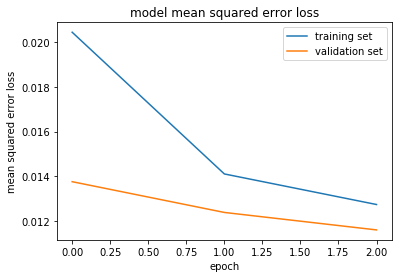

In [4]:
import csv
import os

import cv2
import numpy as np
import sklearn
from sklearn.model_selection import train_test_split


def get_file_name(source_path):
    return source_path.split('/')[-1]

samples = []
skip_line = True
with open('./data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        if skip_line:
            skip_line = False
            continue
        samples.append(line)
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

num_remove = 0
def generator(samples, batch_size=32):
    num_samples = len(samples)
    num_removed = 0
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurements = []
            for line in batch_samples:
                
                source_path = line[0]
                source_path_left = line[1]
                source_path_right = line[2]


                current_path = './data/IMG/' + get_file_name(source_path)
                image = cv2.imread(current_path)
                measurement = float(line[3])
                
                images.append(image)
                images.append(cv2.flip(image,1))
                measurements.append(measurement)
                measurements.append(measurement*-1.0)


                current_path = './data/IMG/' + get_file_name(source_path_left)
                image = cv2.imread(current_path)
                images.append(image)
                images.append(cv2.flip(image,1))
                measurements.append(measurement+0.2)
                measurements.append((measurement+0.2)*-1.0)


                current_path = './data/IMG/' + get_file_name(source_path_right)
                image = cv2.imread(current_path)
                images.append(image)
                images.append(cv2.flip(image,1))
                measurements.append(measurement-0.2)
                measurements.append((measurement-0.2)*-1.0)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(measurements)
            yield sklearn.utils.shuffle(X_train, y_train)
            
# compile and train the model using the generator function
train_generator = generator(train_samples, batch_size=128)
validation_generator = generator(validation_samples, batch_size=128)

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Convolution2D, Dropout

model = Sequential()
model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((70, 25), (0,0))))
model.add(Convolution2D(24,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Convolution2D(64,3,3, activation='relu'))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
history_object = model.fit_generator(train_generator, samples_per_epoch=len(train_samples)*6, validation_data=validation_generator, nb_val_samples=len(validation_samples)*6, nb_epoch=3)

model.save('model.h5')
import matplotlib.pyplot as plt

### print the keys contained in the history object
print(history_object.history.keys())

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()